In [2]:
!python -V

Python 3.9.12


In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/2', experiment_id='2', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [8]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.827368941909366

/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


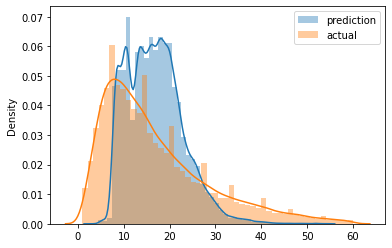

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715206462274

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [20]:
with mlflow.start_run():
    mlflow.set_tag("developper","panayotis")
    mlflow.log_param("train-path-data","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-path-data","./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric("rmse",rmse)

    mlflow.log_artifact(local_path = "models/lin_reg.bin",artifact_path= "models_pickle")

In [23]:
import xgboost as xgb

In [24]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


In [25]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [26]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
       
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [28]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}


In [29]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[22:04:53] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:20.21828                          
[1]	validation-rmse:19.30424                          
[2]	validation-rmse:18.44655                          
[3]	validation-rmse:17.63909                          
[4]	validation-rmse:16.88301                          
[5]	validation-rmse:16.17442                          
[6]	validation-rmse:15.50712                          
[7]	validation-rmse:14.88322                          
[8]	validation-rmse:14.30063                          
[9]	validation-rmse:13.75701                          
[10]	validation-rmse:13.24383                         
[11]	validation-rmse:12.76045                         
[12]	validation-rmse:12.31666                         
[13]	validation-rmse:11.89931                         
[14]	validation-rmse:11.50649                         
[15]	validation-rmse:11.14529                         
[

KeyboardInterrupt: 

In [37]:
params = {
    'learning_rate': 0.37563064,
    'max_depth': 8,
    'min_child_weight':	0.701334452,
    'objective': 'reg:linear',
    'reg_alpha': 0.2417332414228705,
    'reg_lambda': 0.09465585141708521,
    'seed':	42 }


mlflow.xgboost.autolog()
booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50)



2022/05/28 22:25:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1107069f97b44ea38f1c5a3b84392914', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[22:25:44] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.65982
[1]	validation-rmse:10.90918
[2]	validation-rmse:8.87608
[3]	validation-rmse:7.82013
[4]	validation-rmse:7.27929
[5]	validation-rmse:7.00417
[6]	validation-rmse:6.86402
[7]	validation-rmse:6.78353
[8]	validation-rmse:6.74123
[9]	validation-rmse:6.71094
[10]	validation-rmse:6.69243
[11]	validation-rmse:6.68190
[12]	validation-rmse:6.67491
[13]	validation-rmse:6.66855
[14]	validation-rmse:6.66561
[15]	validation-rmse:6.66085
[16]	validation-rmse:6.65802
[17]	validation-rmse:6.65525
[18]	validation-rmse:6.65271
[19]	validation-rmse:6.65035
[20]	validation-rmse:6.64670
[21]	validation-rmse:6.64433
[22]	validation-rmse:6.64291
[23]	validation-rmse:6.64109
[24]	validation-rmse:6.63966
[25]	validation-rmse:6.63518
[26]	validation-rmse:6.63270
[27]	validation-rmse:6.63107
[28]	validation-rmse:6.62837
[29]	validation-rmse:6.62547
[30]	validation-rms

2022/05/28 22:27:05 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2022/05/28 22:27:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ubuntu/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."


In [32]:
# Second way of logging models
with mlflow.start_run():
    params = {
        'learning_rate': 0.37563064,
        'max_depth': 8,
        'min_child_weight':	0.701334452,
        'objective': 'reg:linear',
        'reg_alpha': 0.2417332414228705,
        'reg_lambda': 0.09465585141708521,
        'seed':	42 }

    mlflow.log_params(params) # method logging all the parameters in the dict

    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50)

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b","wb") as f_out:
        pickle.dump(dv,f_out)
    mlflow.log_artifact(local_path = "models/preprocessor.b", artifact_path ="preprocessor")
    mlflow.xgboost.log_model(booster,artifact_path="models_mlflow")

[06:39:13] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.65982
[1]	validation-rmse:10.90918
[2]	validation-rmse:8.87608
[3]	validation-rmse:7.82013
[4]	validation-rmse:7.27929
[5]	validation-rmse:7.00417
[6]	validation-rmse:6.86402
[7]	validation-rmse:6.78353
[8]	validation-rmse:6.74123
[9]	validation-rmse:6.71094
[10]	validation-rmse:6.69243
[11]	validation-rmse:6.68190
[12]	validation-rmse:6.67491
[13]	validation-rmse:6.66855
[14]	validation-rmse:6.66561
[15]	validation-rmse:6.66085
[16]	validation-rmse:6.65802
[17]	validation-rmse:6.65525
[18]	validation-rmse:6.65271
[19]	validation-rmse:6.65035
[20]	validation-rmse:6.64670
[21]	validation-rmse:6.64433
[22]	validation-rmse:6.64291
[23]	validation-rmse:6.64109
[24]	validation-rmse:6.63966
[25]	validation-rmse:6.63518
[26]	validation-rmse:6.63270
[27]	validation-rmse:6.63107
[28]	validation-rmse:6.62837
[29]	validation-rmse:6.62547
[30]	validation-rms

In [33]:
# make predictions with loaded model

logged_model = 'runs:/87f12910ef434f90826be0729339c848/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



[06:48:44] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [34]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 87f12910ef434f90826be0729339c848

In [35]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

[06:52:57] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
xgboost_model

In [36]:
y_pred = xgboost_model.predict(valid)

In [37]:
y_pred

array([15.145195 ,  7.1849194, 15.600891 , ..., 13.700117 ,  7.1849194,
        8.206058 ], dtype=float32)

In [38]:
# utilisation of mlflow client class

from mlflow.tracking import MlflowClient

ML_FLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri = ML_FLOW_TRACKING_URI)

In [46]:
client.list_experiments()


[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/2', experiment_id='2', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>]

In [47]:
client.create_experiment(name="my-cool-experiment")

'3'

In [49]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids = '2',
    filter_string ="",
    run_view_type = ViewType.ACTIVE_ONLY,
    max_results = 5,
    order_by = ["metrics.rmse ASC"]

)

In [50]:
runs

[<Run: data=<RunData: metrics={'rmse': 6.357235543168291}, params={'learning_rate': '0.37563064',
  'max_depth': '8',
  'min_child_weight': '0.701334452',
  'objective': 'reg:linear',
  'reg_alpha': '0.2417332414228705',
  'reg_lambda': '0.09465585141708521',
  'seed': '42'}, tags={'mlflow.log-model.history': '[{"run_id": "87f12910ef434f90826be0729339c848", '
                              '"artifact_path": "models_mlflow", '
                              '"utc_time_created": "2022-05-30 '
                              '06:40:08.526350", "flavors": {"python_function": '
                              '{"loader_module": "mlflow.xgboost", '
                              '"python_version": "3.9.12", "data": "model.xgb", '
                              '"env": "conda.yaml"}, "xgboost": {"xgb_version": '
                              '"1.6.1", "data": "model.xgb", "model_class": '
                              '"xgboost.core.Booster", "code": null}}, '
                              '"model_uu

In [51]:
for run in runs :
    print(f"run id : {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id : 87f12910ef434f90826be0729339c848, rmse: 6.3572
run id : 6c01d551345b43ba883a979c3049f3e8, rmse: 6.3572
run id : 1af07d51214b407fb78f5ec3c73f3261, rmse: 6.3572
run id : 89f7846b66c14997bd0adba1679e0c83, rmse: 6.3572
run id : 3e52aedd84694d8fb771f1d430a6e8fc, rmse: 6.3854


In [52]:
# promote model

mlflow.set_tracking_uri(ML_FLOW_TRACKING_URI)

In [55]:
run_id = "87f12910ef434f90826be0729339c848"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri = model_uri, name ="Xgboost" )

Registered model 'Xgboost' already exists. Creating a new version of this model...
2022/05/30 19:40:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Xgboost, version 1
Created version '1' of model 'Xgboost'.


<ModelVersion: creation_timestamp=1653939617483, current_stage='None', description=None, last_updated_timestamp=1653939617483, name='Xgboost', run_id='87f12910ef434f90826be0729339c848', run_link=None, source='./mlruns/2/87f12910ef434f90826be0729339c848/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [63]:
# transition one model from one stage to another

client.list_registered_models()

[<RegisteredModel: creation_timestamp=1653939591129, description=None, last_updated_timestamp=1653939617483, latest_versions=[<ModelVersion: creation_timestamp=1653939617483, current_stage='None', description=None, last_updated_timestamp=1653939617483, name='Xgboost', run_id='87f12910ef434f90826be0729339c848', run_link=None, source='./mlruns/2/87f12910ef434f90826be0729339c848/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>], name='Xgboost', tags={}>,
 <RegisteredModel: creation_timestamp=1653916225060, description='', last_updated_timestamp=1653940742912, latest_versions=[<ModelVersion: creation_timestamp=1653916248140, current_stage='Staging', description='', last_updated_timestamp=1653916268799, name='nyc-taxi-trip-duration', run_id='6c01d551345b43ba883a979c3049f3e8', run_link='', source='./mlruns/2/6c01d551345b43ba883a979c3049f3e8/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=2>,
  <ModelVersion

In [64]:
model_name = "nyc-taxi-trip-duration"
latest_versions = client.get_latest_versions(name = model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage:{version.current_stage}")

version: 2, stage:Staging
version: 3, stage:None


In [69]:
# transition version 3 from None to Staging
model_version = 3
new_stage = "Staging"
client.transition_model_version_stage(
    name=model_name,
    version = 3,
    stage = new_stage,
    archive_existing_versions= False
)

latest_versions = client.get_latest_versions(name = model_name)
for version in latest_versions:
    print(f"version: {version.version}, stage:{version.current_stage}")

version: 3, stage:Staging


In [75]:
# Anotate a model
from datetime import datetime

date = datetime.today().date()

client.update_model_version(
    name = model_name,
    version = model_version,
    description = f"The model {model_version} was transitioned to stage {new_stage} on {date}."

)

<ModelVersion: creation_timestamp=1653940742912, current_stage='Staging', description='The model 3 was transitioned to stage Staging on 2022-05-30.', last_updated_timestamp=1653941405302, name='nyc-taxi-trip-duration', run_id='1107069f97b44ea38f1c5a3b84392914', run_link='', source='./mlruns/2/1107069f97b44ea38f1c5a3b84392914/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [78]:
# comparing version to use in production
from sklearn.metrics import mean_squared_error
import pandas as pd


def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df


def preprocess(df, dv):
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    categorical = ['PU_DO']
    numerical = ['trip_distance']
    train_dicts = df[categorical + numerical].to_dict(orient='records')
    return dv.transform(train_dicts)


def test_model(name, stage, X_test, y_test):
    model = mlflow.pyfunc.load_model(f"models:/{name}/{stage}")
    y_pred = model.predict(X_test)
    return {"rmse": mean_squared_error(y_test, y_pred, squared=False)}


In [80]:
#load data for test
df = read_dataframe("../data/green_tripdata_2021-03.parquet")

In [88]:
# download artifacts for the run (dv vectorizer)
run_id = "87f12910ef434f90826be0729339c848"
client.download_artifacts(run_id = run_id, path='preprocessor')

import pickle 
with open("models/preprocessor.b","rb") as f_in:
    dv = pickle.load(f_in)

In [90]:
X_test = preprocess(df,dv)


In [91]:
target = "duration"
y_test = df[target].values


In [93]:
model_name

'nyc-taxi-trip-duration'

In [96]:
%time test_model(name = model_name, stage = "Production",X_test = X_test,y_test = y_test )

[20:47:31] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 6.46 s, sys: 7.18 ms, total: 6.47 s
Wall time: 5.28 s


{'rmse': 6.297138984975371}

In [95]:
%time test_model(name = model_name, stage = "Staging",X_test = X_test,y_test = y_test )

[20:47:22] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 6.23 s, sys: 3.77 ms, total: 6.23 s
Wall time: 3.31 s


{'rmse': 6.297138984975371}